<a href="https://colab.research.google.com/github/Romira915/jds_compe/blob/main/compe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  !pip install mecab-python3 transformers fugashi ipadic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 574 kB 25.5 MB/s 
     |████████████████████████████████| 4.4 MB 47.2 MB/s 
     |████████████████████████████████| 568 kB 38.6 MB/s 
     |████████████████████████████████| 13.4 MB 57.7 MB/s 
     |████████████████████████████████| 101 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 59.1 MB/s 
     |████████████████████████████████| 6.6 MB 51.8 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=33d7cc3ad1ebded535fcb2fd283eb10f1f9f071102a84528324980276dce71a0
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import copy
import time

import MeCab
import numpy as np
import pandas as pd
import torch
import transformers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import Tensor, cuda, optim
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoModel, AutoTokenizer, BertJapaneseTokenizer,
                          BertModel, BartForSequenceClassification)

In [3]:
train_path = "train.csv"
test_path = "test.csv"
compe_path = "compe.csv"

try:
  from google.colab import drive
  drive.mount('/content/drive')

  compe_dir = "/content/drive/My Drive/Documents/compe/"

  train_path = compe_dir + train_path
  test_path = compe_dir + test_path
  compe_path = compe_dir + compe_path

except ImportError:
  pass

Mounted at /content/drive


In [4]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
compe_df = pd.read_csv(compe_path)

train_df, valid_df = train_test_split(
    train_df, test_size=0.2, shuffle=True)

train_text = train_df["text"].values.astype('U')
valid_text = valid_df["text"].values.astype('U')
test_text = test_df["text"].values.astype('U')
y = train_df["label"].values.astype("int8")
valid_y = valid_df["label"].values.astype("int8")
test_y = test_df["label"].values.astype("int8")
compe_text = compe_df["text"].values.astype('U')

# model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
# model_name = "daigo/bert-base-japanese-sentiment"
model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"

tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

In [5]:
# Datasetの定義
class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            pad_to_max_length=True,
            # padding=True, 
            truncation=True,
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if self.max_len < sum(mask):
          i = int(self.max_len / 2)
          tmp = copy.copy(ids[:i])
          tmp.extend(ids[sum(mask) - i:sum(mask)])
          ids = tmp
          tmp = copy.copy(mask[:i])
          tmp.extend(mask[sum(mask) - i:sum(mask)])
          mask = tmp
        else:
          ids = ids[:self.max_len]
          mask = mask[:self.max_len]

        y_tensor = torch.Tensor(
            [1, 0]) if self.y[index] == 0 else torch.Tensor([0, 1])

        return {
            'ids': torch.LongTensor(ids),
            'mask': torch.LongTensor(mask),
            'labels': y_tensor
        }

In [6]:
# 最大系列長の指定
MAX_LEN = 128

# tokenizerの取得
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)

# Datasetの作成
dataset_train = CreateDataset(
    train_text, y, tokenizer, MAX_LEN)
dataset_valid = CreateDataset(
    valid_text, valid_y, tokenizer, MAX_LEN)
dataset_test = CreateDataset(
    test_text, test_y, tokenizer, MAX_LEN)

for var in dataset_train[3260]:
    print(f'{var}: {dataset_train[3260][var]}')

ids: tensor([    2, 17232, 13817,  1868, 19493,  2366, 28825, 28825,   266,   227,
        28594,  3811,   761, 28468,    16,  1025, 28461,   312, 22752,    10,
            5,    54,    23, 28473,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [7]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for i, sent in enumerate(train_text):
    # Tokenizeで分割
    token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
    if len(token_words) == 136:
      print(i)
# 最大の値を確認
print('最大単語数: ', max(max_len))

6736
最大単語数:  136


In [8]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
    def __init__(self, pretrained, drop_rate, output_size):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained)
        self.drop = torch.nn.Dropout(drop_rate)
        self.fc = torch.nn.Linear(768, output_size)  # BERTの出力に合わせて768次元を指定

    def forward(self, ids, mask):
        _, out = self.bert(ids, attention_mask=mask, return_dict=False)
        out = self.fc(self.drop(out))
        return out

In [9]:
def calculate_loss_and_accuracy(model, loader, device, criterion=None):
    """ 損失・正解率を計算"""
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            # 順伝播
            outputs = model(ids, mask)

            # 損失計算
            if criterion != None:
                loss += criterion(outputs, labels).item()

            # 正解率計算
            # バッチサイズの長さの予測ラベル配列
            pred = torch.argmax(outputs, dim=-1).cpu().numpy()
            # バッチサイズの長さの正解ラベル配列
            labels = torch.argmax(labels, dim=-1).cpu().numpy()
            total += len(labels)
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total

In [10]:
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
    """モデルの学習を実行し、損失・正解率のログを返す"""
    # デバイスの指定
    model.to(device)

    # dataloaderの作成
    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    # 学習
    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for data in dataloader_train:
            # デバイスの指定
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # 順伝播 + 誤差逆伝播 + 重み更新
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            # loss = outputs.loss
            loss.backward()

            del loss
            
            optimizer.step()

        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(
            model, dataloader_train, device, criterion=criterion)
        loss_valid, acc_valid = calculate_loss_and_accuracy(
            model, dataloader_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    return {'train': log_train, 'valid': log_valid}

In [11]:
torch.cuda.empty_cache()
# パラメータの設定
DROP_RATE = 0.7
OUTPUT_SIZE = 2
BATCH_SIZE = 8
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(model_name, DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE,
                  model, criterion, optimizer, NUM_EPOCHS, device=device)

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` a

epoch: 1, loss_train: 0.1137, accuracy_train: 0.9613, loss_valid: 0.1811, accuracy_valid: 0.9230, 290.8190sec
epoch: 2, loss_train: 0.0597, accuracy_train: 0.9810, loss_valid: 0.2079, accuracy_valid: 0.9290, 297.2023sec
epoch: 3, loss_train: 0.0191, accuracy_train: 0.9955, loss_valid: 0.2203, accuracy_valid: 0.9290, 297.5074sec
epoch: 4, loss_train: 0.0097, accuracy_train: 0.9972, loss_valid: 0.3170, accuracy_valid: 0.9305, 296.9604sec


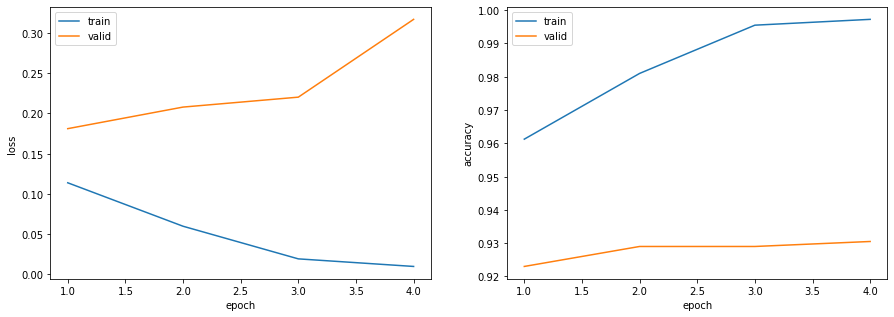

In [12]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [13]:
# 正解率の算出
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

print(
    f'正解率（学習データ）：{calculate_loss_and_accuracy(model, dataloader_train, device)[1]:.3f}')
print(
    f'正解率（検証データ）：{calculate_loss_and_accuracy(model, dataloader_valid, device)[1]:.3f}')
print(
    f'正解率（評価データ）：{calculate_loss_and_accuracy(model, dataloader_test, device)[1]:.3f}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


正解率（学習データ）：0.997
正解率（検証データ）：0.930
正解率（評価データ）：0.936
